# Load data and create plots of spherical (icosahedral) data

In [2]:
from scipy.spatial import SphericalVoronoi

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib

import numpy as np
import os.path
import netCDF4
from sklearn.model_selection import train_test_split

from icosahedron import Icosahedron, rand_rotation_icosahedron, rand_rotation_matrix, plot_voronoi, plot_voronoi_charts

In [3]:
DIRECTORY_DATASETS_ORIGINAL = "Datasets/Original/"
DIRECTORY_DATASETS_INTERPOLATED = "Datasets/Interpolated/"
DIRECTORY_IMAGES = "Images/"
DIRECTORY_OUTPUTS = "Output/"

# Load data.

### Select how we want to join datasets

Of course corresponding .nc files have to be in the given directory

In [5]:
dataset_description = {}

dataset_description["GRID"] = "Ico"
dataset_description["RESOLUTION"] = 5  # resolution of the icosahedron
dataset_description["DSET_NB"] = 1 # if we want to shuffle we might want to create more than one dataset with the same config.

dataset_description["DO_SHUFFLE"] = False
dataset_description["INTERPOLATE_CORNERS"] = True # use cdo to get interpolated values for corners. If False: Insert zeros.
dataset_description["INTERPOLATION"] = "cons1" # other option: NN

shuffle_dict = {True:"shuffle", False:"no-shuffle"}

corners_dict = {True: "interp-corners", False: "zero-fill-corners"}

In [6]:
def get_dataset_dict(path_ds_6_nb, path_ds_5_nb=None):
    """
    Returns a dict that contains the Datasets stored in path_ds_5_nb and path_ds_6_nb. As the names suggest,
    these should be the the datasets containing all points with 5 and all points with six neighbors.
    If only one dataset is used (should be path_ds_6_nb), set the other argument to None.
    """
    import netCDF4
    
    datasets = {}
    
    datasets["6_nb"] = netCDF4.Dataset(path_ds_6_nb, "a")
    if path_ds_5_nb is not None:
        datasets["5_nb"] = netCDF4.Dataset(path_ds_5_nb, "a")
    return datasets

In [27]:
dataset_description["datasets_used"] = ["isotopes", "temp", "precip", "oro"]#]#, "slp"]#, 

# list which variables should be used in each of the datasets.
dataset_description["variables_used"] = {dataset_description["datasets_used"][0]: ["dO18"],
                                         dataset_description["datasets_used"][1]: ["temp_1"],
                                         dataset_description["datasets_used"][2]: ["precip"],
                                         # dataset_description["datasets_used"][3]: ["p"],
                                         dataset_description["datasets_used"][3]: ["ht"],
                                         }
# make sure no variable gets extracted twice
all_variables = [var for varlist in dataset_description["variables_used"].values() for var in varlist]
assert len(all_variables) == len(set(all_variables)), "Variables names must be unique"
all_variables = np.sort(all_variables) # sort: we want to use this in filename later and must make sure it yields same result for permutation.


# which variables should be predictors and/or targets?
dataset_description["predictor_variables"] = ["temp_1", "precip", "ht"]#]#,"p"]#, "ht"]
dataset_description["target_variables"] = ["dO18"]

for pvar in dataset_description["predictor_variables"]:
    assert pvar in all_variables, "Specified predictor variable not selected when loading from datasets"
for tvar in dataset_description["target_variables"]:
    assert tvar in all_variables, "Specified target variable not selected when loading from datasets"

for var in all_variables:
    assert var in dataset_description["predictor_variables"] or var in dataset_description["target_variables"], "Loaded variable(s) not used."

In [28]:
dataset_description["files_used"] = []
datasets = {}

for dst in dataset_description["datasets_used"]: 
    if dataset_description["INTERPOLATE_CORNERS"]:
        name6 = os.path.join(DIRECTORY_DATASETS_INTERPOLATED, "xnapa_{}_r_{}_nbs_6_{}.nc".format(dst,\
                                                                                                 dataset_description["RESOLUTION"],\
                                                                                                 dataset_description["INTERPOLATION"]))
        name5 = os.path.join(DIRECTORY_DATASETS_INTERPOLATED, "xnapa_{}_r_{}_nbs_5_{}.nc".format(dst,\
                                                                                                 dataset_description["RESOLUTION"],\
                                                                                                 dataset_description["INTERPOLATION"]))
        datasets[dst] = get_dataset_dict(name6, name5)
        dataset_description["files_used"].append(name6)
        dataset_description["files_used"].append(name5)

    else:
        name6 = os.path.join(DIRECTORY_DATASETS_INTERPOLATED, "xnapa_isotopes_r_{}_nbs_6_{}.nc".format(dst,\
                                                                                                       dataset_description["RESOLUTION"],\
                                                                                                       dataset_description["INTERPOLATION"]))
        datasets[dst] = get_dataset_dict(name6)
        dataset_description["files_used"].append(name6)

In [29]:
# this will be used later to automatically extract info about the target var:
for name, dset in datasets.items():
    print(name)
    for name, var in dset["6_nb"].variables.items():
        print(f'\tName: {var.name}')
        if hasattr(var, 'long_name'):
            print(f'\tLong name: {var.long_name}')
        print(f'\tDimensions: {var.dimensions}')
        if hasattr(var, 'units'):
            print(f'\tUnits: {var.units}')
        print('\n')

isotopes
	Name: t
	Long name: t
	Dimensions: ('t',)
	Units: days since 2350-12-01 00:00:00


	Name: t_bnds
	Dimensions: ('t', 'bnds')


	Name: lon
	Long name: longitude
	Dimensions: ('ncells',)
	Units: degrees_east


	Name: lon_bnds
	Dimensions: ('ncells', 'vertices')


	Name: lat
	Long name: latitude
	Dimensions: ('ncells',)
	Units: degrees_north


	Name: lat_bnds
	Dimensions: ('ncells', 'vertices')


	Name: level-1_4
	Long name: Field code =    -1
	Dimensions: ('level-1_4',)
	Units:  


	Name: level-1_5
	Long name: Field code =    -1
	Dimensions: ('level-1_5',)
	Units:  


	Name: level-1_6
	Long name: Field code =    -1
	Dimensions: ('level-1_6',)
	Units:  


	Name: h2o
	Dimensions: ('t', 'level-1_4', 'ncells')


	Name: dO18
	Dimensions: ('t', 'level-1_5', 'ncells')


	Name: dD
	Dimensions: ('t', 'level-1_6', 'ncells')


temp
	Name: t
	Long name: t
	Dimensions: ('t',)
	Units: days since 2350-12-01 00:00:00


	Name: t_bnds
	Dimensions: ('t', 'bnds')


	Name: lon
	Long name: longitude


In [30]:
# names of datasets to which we want not to be missing at any timestep.
dnames = [DIRECTORY_DATASETS_ORIGINAL+"xnapa_isotopes.nc",\
          DIRECTORY_DATASETS_ORIGINAL+"xnapa_precip.nc",\
          DIRECTORY_DATASETS_ORIGINAL+"xnapa_slp.nc",\
          DIRECTORY_DATASETS_ORIGINAL+"xnapa_temp.nc"]

def get_shared_timesteps(dataset_names):
    """
    Not all datasets share the same timesteps. The biggest problems occur in the slp dataset. We want to exclude all
    time steps where one of the variables is missing
    """
    
    # get indices of elements that are shared for all variables.
    from functools import reduce
    ts = tuple([netCDF4.Dataset(dataset_name,"a").variables["t"][:].data for dataset_name in dataset_names])
    common_dates = reduce(np.intersect1d, ts)
    
    return common_dates

In [31]:
# somehow two frames are excluded - why???? -> the dO18 datset is 2 timesteps smaller, but the time
# axis actually has the same size...

#import the precipitation, reshape and remove the points at north and south pole

variables = {}

for dataset_name, dataset in datasets.items():  # loop over all used datasets
    variables[dataset_name] = {} # create a dict to store files from 5-nb and 6-nb files
    for variable_name in dataset_description["variables_used"][dataset_name]: # loop over all variables we want to use from this dataset
        variables[dataset_name][variable_name] = {} # create a dict to store files from 5-nb and 6-nb files        
        for subdataset_name, subdataset in dataset.items():  # loop over subfiles: containing points with 5 and 6 nbs
            if subdataset.variables[variable_name][:].data.shape[0] > 1 : # only if time dimenion is not trivial
                c_dates = get_shared_timesteps(dnames)
                # get the corresponding indices:
                indices = []
                for i, t in enumerate(subdataset.variables["t"][:].data):
                    if t in c_dates:
                        indices.append(i)
                indices = np.array(indices)                    
                index_mask = np.logical_and(subdataset.variables["t"][indices].data // 360 >= 654, \
                                            subdataset.variables["t"][indices].data // 360 < 1654)    
                indices = indices[index_mask]
                # load dataset, neglect first (invalid) timesteps and only take first 1000 steps of what remains
                variables[dataset_name][variable_name][subdataset_name] = np.squeeze(subdataset.variables[variable_name][:].data)[indices,:]
            else: 
                variables[dataset_name][variable_name][subdataset_name] = np.squeeze(np.repeat(subdataset.variables[variable_name][:].data, repeats=len(indices), axis=0))

In [32]:
def combine_datasets(dataset_dict, indices_five_nb, indices_six_nb):
    """
    We need to combine the datasets from the seperate files for points with 5 nbs and points with 6 nbs.
    If there only is a file with six-neighbor points, we fill with zeros. 
    """
    assert "6_nb" in dataset_dict.keys()
    combined_data = np.zeros(dataset_dict["6_nb"].shape[:-1] + (dataset_dict["6_nb"].shape[-1]+10,))
    if "5_nb" in dataset_dict.keys():
        combined_data[:,indices_six_nb] = dataset_dict["6_nb"]
        combined_data[:,indices_five_nb] = dataset_dict["5_nb"]
    else:
        combined_data[:,indices_six_nb] = dataset_dict["6_nb"]
        combined_data[:,indices_five_nb] = 0
    return combined_data

In [33]:
ico = Icosahedron(r=dataset_description["RESOLUTION"])
regions, vertices = ico.get_voronoi_regions_vertices()
charts = ico.get_charts_cut()
indices_six_nb = []
indices_five_nb = []
for i in range(len(regions)):
    if len(regions[i])>5:
        indices_six_nb.append(i)
    else:
        indices_five_nb.append(i)
# create numpy arrays
indices_six_nb = np.array(indices_six_nb)
indices_five_nb = np.array(indices_five_nb)

In [34]:
variables_combined = {}

for dataset_name, dataset in variables.items():  # loop over all used datasets
    for variable_name in dataset_description["variables_used"][dataset_name]: # loop over all variables we want to use from this dataset
        variables_combined[variable_name] = combine_datasets(dataset[variable_name], indices_five_nb, indices_six_nb)  # we assured earlier, that variable names are unique

# reshape to the correct format:
for key, array in variables_combined.items():
    array = array.reshape(array.shape[0], -1, charts.shape[-2])

In [35]:
predictors = np.concatenate(tuple([variables_combined[p_var] for p_var in dataset_description["predictor_variables"]]),axis=1)

targets = np.concatenate(tuple([variables_combined[t_var] for t_var in dataset_description["target_variables"]]),axis=1)


In [36]:
indices = np.arange(predictors.shape[0])
X_train, X_test, Y_train, Y_test, indices_train, indices_test = train_test_split(predictors, targets, indices, 
                                                                                 test_size=0.1, shuffle = dataset_description["DO_SHUFFLE"])

dataset_description["indices_train"] = indices_train
dataset_description["indices_test"] = indices_test  

In [37]:
X_train = X_train.reshape(X_train.shape[0], len(dataset_description["predictor_variables"]), -1, charts.shape[-2]) 
X_test =  X_test.reshape(X_test.shape[0], len(dataset_description["predictor_variables"]), -1, charts.shape[-2])
Y_train = Y_train.reshape(Y_train.shape[0],len(dataset_description["target_variables"]), -1, charts.shape[-2])
Y_test = Y_test.reshape(Y_test.shape[0],len(dataset_description["target_variables"]), -1, charts.shape[-2])
dataset = {}

dataset['test'] = {
    'predictors': X_test,
    'targets': Y_test
}
dataset['train'] = {
    'predictors': X_train,
    'targets': Y_train
}

# Develop a new plotting function that works with Cartopy and allows us to plot continents.

In [38]:
def cartesian_to_spherical(data):
    """
    convert cartesian coordinates to spherical coordinates
    Use answer to:
    https://stackoverflow.com/questions/4116658/faster-numpy-cartesian-to-spherical-coordinate-conversion
    """
    # takes list xyz (single coord)
    x = data[..., 0]
    y = data[..., 1]
    z = data[..., 2]
    r = np.sqrt(x * x + y * y + z * z)
    # format in HadCM3: lat:(-90,90), lon(0,360)
    theta = 90 - np.arccos(z / r) * 180 / np.pi  # to degrees
    phi = 180 + np.arctan2(y, x) * 180 / np.pi
    return np.array([theta, phi]).transpose((1, 0))  # careful, this will only work if the shape is correct

def plot_ico_lattice_map(data, vertices, regions, cmap=None, norm=None, show_continents=True, 
                         figsize=(15,10), projection=ccrs.Robinson()):
    """
    Plot a single image given in ico_resolution. Assume shape is (npixels,).
    """
    import cartopy.feature as cf
    
    assert len(data.shape) == 1
    if vertices.shape[-1]!=2:  # 'if vertices are not in spherical format already'   
        spherical_vertices = cartesian_to_spherical(vertices)
        spherical_vertices_plot = np.zeros_like(spherical_vertices)
        spherical_vertices_plot[:,0] = spherical_vertices[:,1]# longitude
        spherical_vertices_plot[:,0][spherical_vertices_plot[:,0] == 360] = 0# longitude
        spherical_vertices_plot[:,1] = spherical_vertices[:,0]# latitude
    else:
        spherical_vertices_plot = np.zeros_like(vertices)
        spherical_vertices_plot[:,0] = vertices[:,1]# longitude
        spherical_vertices_plot[:,0][spherical_vertices_plot[:,0] == 360] = 0# longitude
        spherical_vertices_plot[:,1] = vertices[:,0]# latitude        
    import matplotlib.pyplot as plt
    import matplotlib.patches as mpatches
    from matplotlib.collections import PatchCollection

    # plotting
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(projection=projection)

    if cmap is None:
        cmap = plt.get_cmap("plasma")
    if norm is None:
        dmin = min(data)
        dmax = max(data)

    patches = []


    for i in range(len(regions)):
        tmp = spherical_vertices_plot[regions[i]]
        # Polygons that lie close to the 0°-360° continuity get connected wrongly by cartopy. We fix this for now
        # Solution is not perfect.
        if np.amax(tmp[:,0])- np.amin(tmp[:,0]) > 180: 
            tmp[tmp>180] = tmp[tmp>180]-360
        polygon = mpatches.Polygon(tmp,
                          transform=ccrs.PlateCarree())
        if norm is None:
            polygon.set_color(cmap(np.array((data[i]-dmin)/(dmax-dmin))))
        else:
            polygon.set_color(cmap(norm(data[i])))
        ax.add_patch(polygon)

    ax.set_global()
    # ax.coastlines(alpha=0.5)
    plt.show()

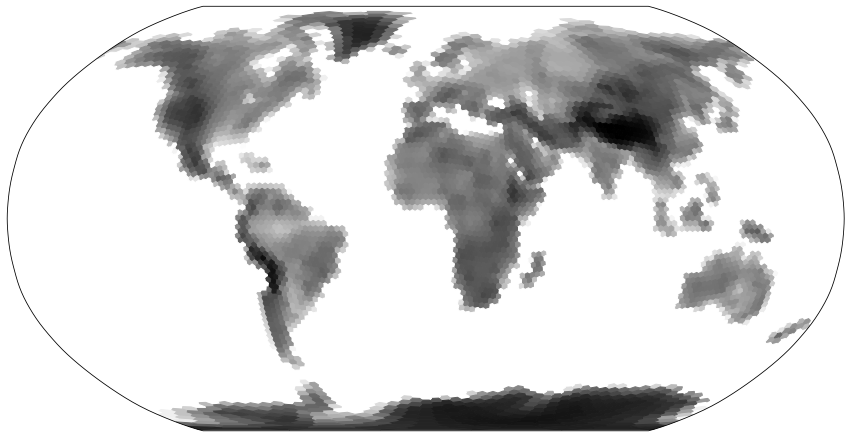

In [39]:
data = predictors.reshape(predictors.shape[0],len(dataset_description["predictor_variables"]), -1)[0,-1,...]
cmap = plt.get_cmap("Greys")
norm = matplotlib.colors.PowerNorm(gamma=0.2 ,vmin=np.amin(data), vmax=np.amax(data))
plot_ico_lattice_map(data, vertices, regions, norm=norm, cmap=cmap)
# plt.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap))

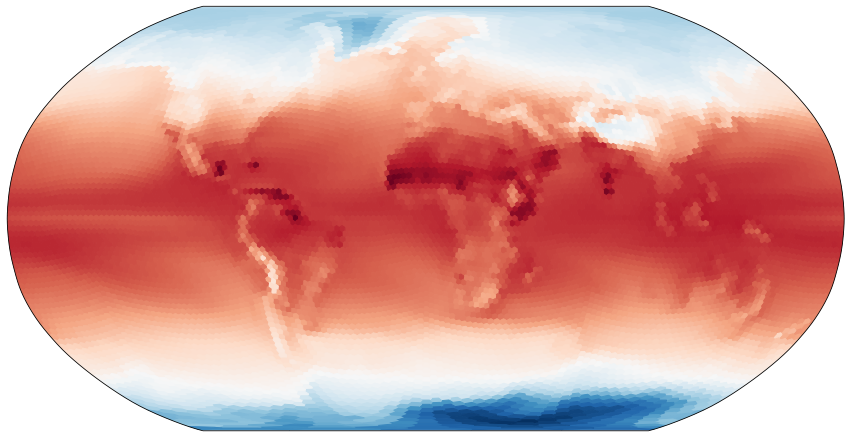

In [40]:
data = predictors.reshape(predictors.shape[0],len(dataset_description["predictor_variables"]), -1)[0,0,...]
cmap = plt.get_cmap("RdBu_r")
norm = matplotlib.colors.TwoSlopeNorm(vmin=np.amin(data),vmax=np.amax(data),vcenter=0)
plot_ico_lattice_map(data, vertices, regions, norm=norm, cmap=cmap)

## some more plotting

In [41]:
# reshape to the correct format:
tas_combined = predictors.reshape(predictors.shape[0],len(dataset_description["predictor_variables"]), -1)[:,0,...]
pr_combined = predictors.reshape(predictors.shape[0],len(dataset_description["predictor_variables"]), -1)[:,1,...]
oro_combined = predictors.reshape(predictors.shape[0],len(dataset_description["predictor_variables"]), -1)[:,-1,...]
d18O_combined = targets[...]

In [42]:
class FixPointNormalize(matplotlib.colors.Normalize):
    """ 
    Inspired by https://stackoverflow.com/questions/20144529/shifted-colorbar-matplotlib
    Subclassing Normalize to obtain a colormap with a fixpoint 
    somewhere in the middle of the colormap.

    This may be useful for a `terrain` map, to set the "sea level" 
    to a color in the blue/turquise range. 
    """
    def __init__(self, vmin=None, vmax=None, sealevel=0, col_val = 0.21875, clip=False):
        # sealevel is the fix point of the colormap (in data units)
        self.sealevel = sealevel
        # col_val is the color value in the range [0,1] that should represent the sealevel.
        self.col_val = col_val
        matplotlib.colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.sealevel, self.vmax], [0, self.col_val, 1]
        return np.ma.masked_array(np.interp(value, x, y))

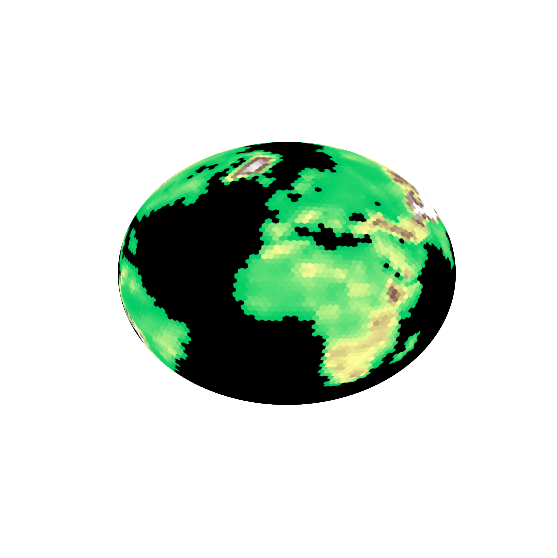

In [44]:
norm = FixPointNormalize(sealevel=0.01, vmax=3000)
colors_undersea = plt.cm.terrain(np.linspace(0.24, 0.25, 56))
colors_land = plt.cm.terrain(np.linspace(0.25, 1, 200))
colors = np.vstack((colors_undersea, colors_land))
cmap = matplotlib.colors.LinearSegmentedColormap.from_list('cut_terrain', colors)

plot_voronoi(oro_combined[0,:].reshape(-1), regions, vertices, cmap=cmap, norm=norm, elev=18)
plt.axis("off")
plt.savefig(os.path.join(DIRECTORY_IMAGES, "oro_sphere.jpg"))
plt.savefig(os.path.join(DIRECTORY_IMAGES, "oro_sphere.png"))
plt.savefig(os.path.join(DIRECTORY_IMAGES, "oro_sphere.pdf"))
plt.show()

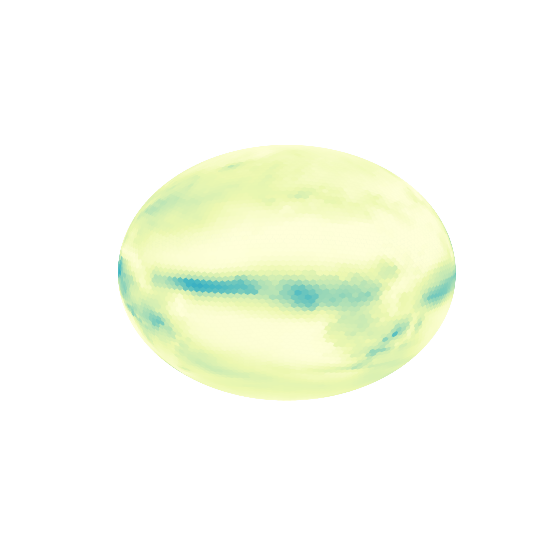

In [45]:
cmap = plt.get_cmap("YlGnBu")
plot_voronoi(pr_combined[0,:].reshape(-1), regions, vertices,cmap=cmap, elev=8)
plt.axis("off")
plt.savefig(os.path.join(DIRECTORY_IMAGES, "pr_ico.jpg"))
plt.savefig(os.path.join(DIRECTORY_IMAGES, "pr_ico.png"))
plt.savefig(os.path.join(DIRECTORY_IMAGES, "pr_ico.pdf"))
plt.show()

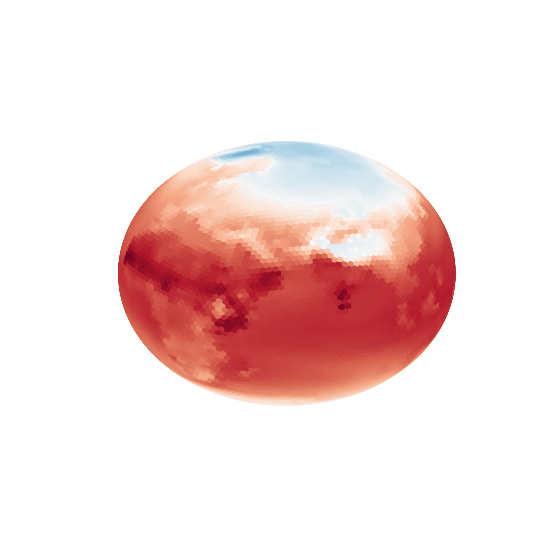

In [46]:
cmap = plt.get_cmap("RdBu_r")
norm = matplotlib.colors.TwoSlopeNorm(vmin=np.amin(tas_combined[0,...]),vmax=np.amax(tas_combined[0,...]),vcenter=0)

plot_voronoi(tas_combined[0,...], regions, vertices, elev=20,azim=60, cmap=cmap, norm=norm)
plt.axis("off")
plt.savefig(os.path.join(DIRECTORY_IMAGES, "tas_ico.jpg"))
plt.savefig(os.path.join(DIRECTORY_IMAGES, "tas_ico.png"))
plt.savefig(os.path.join(DIRECTORY_IMAGES, "tas_ico.pdf"))
plt.show()
plt.close()

In [47]:
# reshape to the correct format:
tas_combined = tas_combined.reshape(tas_combined.shape[0], 5, -1, charts.shape[-2])
pr_combined = pr_combined.reshape(pr_combined.shape[0], 5, -1, charts.shape[-2])
d18O_combined = d18O_combined.reshape(d18O_combined.shape[0], 5, -1, charts.shape[-2])

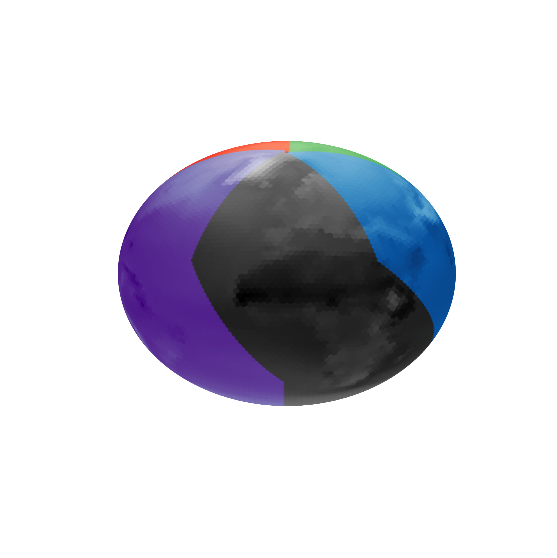

In [48]:
plot_voronoi_charts(tas_combined[0,...], regions, vertices, elev=20)
plt.axis('off')
plt.savefig(os.path.join(DIRECTORY_IMAGES, "tas_charts.jpg"))
plt.savefig(os.path.join(DIRECTORY_IMAGES, "tas_charts.png"))
plt.savefig(os.path.join(DIRECTORY_IMAGES, "tas_charts.pdf"))
plt.show()
plt.close()

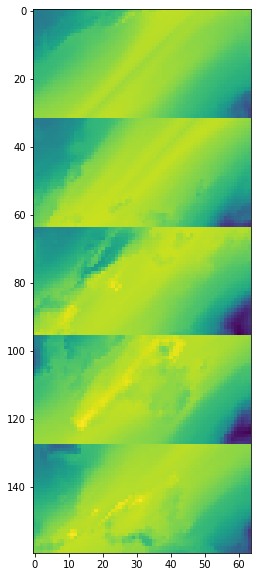

In [49]:
# reshape to the correct format:
tas_combined = tas_combined.reshape(tas_combined.shape[0], -1, charts.shape[-2])
pr_combined = pr_combined.reshape(pr_combined.shape[0], -1, charts.shape[-2])
d18O_combined = d18O_combined.reshape(d18O_combined.shape[0], -1, charts.shape[-2])

plt.figure(figsize=(5,10))
plt.imshow(tas_combined[0,...])
plt.show()